In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare

In [2]:
df = acquire.get_titanic_data()
df.head(2)

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0


In [3]:
# Reduce obvious noise
df = df.set_index("passenger_id")
df = df.drop(columns=["class", "embarked"])

In [4]:
# What about nulls?
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
deck           688
embark_town      2
alone            0
dtype: int64

In [5]:
# Drop deck because there are far too many nulls
df = df.drop(columns=["deck"])

In [6]:
# Let's fill embark_town with the most common observation
df.embark_town = df.embark_town.fillna(value=df.embark_town.mode())

In [7]:
# Let's investigate the observations with missing age
# My first thought was empty age values might indicate children
# Looks like most of these individuals were traveling alone
no_age_info = df[df.age.isna()]
no_age_info.alone.value_counts()

1    133
0     44
Name: alone, dtype: int64

(<AxesSubplot:>, <AxesSubplot:>)

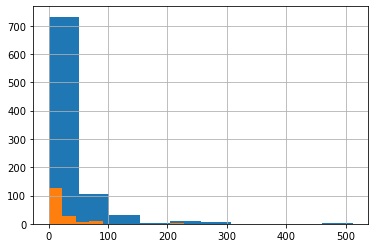

In [8]:
df.fare.hist(), no_age_info.fare.hist()

In [9]:
# Let's see how similar this group is to the population
for column in df.drop(columns=["age", "fare"]).columns:
    print(column)
    print("Population:")
    print(df[column].value_counts(normalize=True))
    print("No age")
    print(no_age_info[column].value_counts(normalize=True))
    print()
    print()

survived
Population:
0    0.616162
1    0.383838
Name: survived, dtype: float64
No age
0    0.706215
1    0.293785
Name: survived, dtype: float64


pclass
Population:
3    0.551066
1    0.242424
2    0.206510
Name: pclass, dtype: float64
No age
3    0.768362
1    0.169492
2    0.062147
Name: pclass, dtype: float64


sex
Population:
male      0.647587
female    0.352413
Name: sex, dtype: float64
No age
male      0.700565
female    0.299435
Name: sex, dtype: float64


sibsp
Population:
0    0.682379
1    0.234568
2    0.031425
4    0.020202
3    0.017957
8    0.007856
5    0.005612
Name: sibsp, dtype: float64
No age
0    0.774011
1    0.146893
8    0.039548
3    0.022599
2    0.016949
Name: sibsp, dtype: float64


parch
Population:
0    0.760943
1    0.132435
2    0.089787
5    0.005612
3    0.005612
4    0.004489
6    0.001122
Name: parch, dtype: float64
No age
0    0.887006
2    0.067797
1    0.045198
Name: parch, dtype: float64


embark_town
Population:
Southampton    0.724409
Cherbou

In [10]:
# Looking at the distribution of values, it appears that no age subgroup is very close to the population
# If we needed to be more certain, we could perform hypothesis testing
# It looks like there's nothing wildly different about the no age group compared to the population
# So we'll impute using the median age
df.age = df.age.fillna(value=df.age.median())

In [11]:
# Time to encode the encodeable!
dummy_df = pd.get_dummies(df[['sex','embark_town']], dummy_na=False, drop_first=[True, True])

# Drop the original columns we encoded
df = df.drop(columns=["sex", "embark_town"])

# Stitch the df and the dummy_df together again
df = pd.concat([df, dummy_df], axis=1)
df.head()

,survived,pclass,age,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
passenger_id,,,,,,,,,,
0,0,3,22.0,1,0,7.2500,0,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,0,1
4,0,3,35.0,0,0,8.0500,1,1,0,1


In [12]:
# Time to split!
train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df.survived)
train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train.survived)

In [13]:
X_train = train.drop(columns=["survived"])
y_train = train.survived

X_validate = validate.drop(columns=["survived"])
y_validate = validate.survived

X_test = test.drop(columns=["survived"])
y_test = test.survived

# 1
What is your baseline prediction? 

What is your baseline accuracy? 

remember: your baseline prediction for a classification problem is predicting the most prevelant class in the training dataset (the mode). 

When you make those predictions, what is your accuracy? 

This is your baseline accuracy.

In [14]:
y_train[0:10]

passenger_id
583    0
165    1
50     0
259    1
306    1
308    0
314    0
883    0
459    0
180    0
Name: survived, dtype: int64

In [15]:
train.survived.value_counts()

0    307
1    191
Name: survived, dtype: int64

In [16]:
# The mode is a great baseline
baseline = y_train.mode()

# Produce a boolean array with True representing a match between the baseline prediction and reality
matches_baseline_prediction = (y_train == 0)

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: 0.62


In [17]:
# Make the model
tree1 = DecisionTreeClassifier(max_depth=1, random_state=123)

# Fit the model (on train and only train)
tree1 = tree1.fit(X_train, y_train)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = tree1.predict(X_train)

In [ ]:
plt.figure(figsize=(12,7))
plot_tree(tree1, feature_names = X)

In [18]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(tree1.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.80


In [19]:
# confusion matrix - actual on left, predicted on top
pd.DataFrame(confusion_matrix(y_train, y_predictions))

,0,1
0,265,42
1,58,133


In [20]:
pd.crosstab(y_train, y_predictions)

col_0,0,1
survived,,
0,265,42
1,58,133


In [21]:
print(classification_report(y_train, y_predictions))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       307
           1       0.76      0.70      0.73       191

    accuracy                           0.80       498
   macro avg       0.79      0.78      0.78       498
weighted avg       0.80      0.80      0.80       498



In [22]:
# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 1 depth")
pd.DataFrame(report)

Tree of 1 depth


,0,1,accuracy,macro avg,weighted avg
precision,0.820433,0.760000,0.799197,0.790217,0.797255
recall,0.863192,0.696335,0.799197,0.779764,0.799197
f1-score,0.841270,0.726776,0.799197,0.784023,0.797358
support,307.000000,191.000000,0.799197,498.000000,498.000000


In [23]:
# If not-survived is our positive case
TP = 265
FP = 58
FN = 42
TN = 133
ALL = TP + FP + FN + TN

accuracy = (TP + TN)/ALL
print(f"Accuracy: {accuracy}")

true_positive_rate = TP/(TP+FN)
print(f"True Positive Rate: {true_positive_rate}")

false_positive_rate = FP/(FP+TN)
print(f"False Positive Rate: {false_positive_rate}")

true_negative_rate = TN/(TN+FP)
print(f"True Negative Rate: {true_negative_rate}")

false_negative_rate = FN/(FN+TP)
print(f"False Negative Rate: {false_negative_rate}")

precision = TP/(TP+FP)
print(f"Precision: {precision}")

recall = TP/(TP+FN)
print(f"Recall: {recall}")

f1_score = 2*(precision*recall)/(precision+recall)
print(f"F1 Score: {f1_score}")

support_pos = TP + FN
print(f"Support (0): {support_pos}")

support_neg = FP + TN
print(f"Support (1): {support_neg}")

Accuracy: 0.7991967871485943
True Positive Rate: 0.8631921824104235
False Positive Rate: 0.3036649214659686
True Negative Rate: 0.6963350785340314
False Negative Rate: 0.13680781758957655
Precision: 0.8204334365325078
Recall: 0.8631921824104235
F1 Score: 0.8412698412698413
Support (0): 307
Support (1): 191


In [24]:

for i in range(2, 21):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = tree.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
                    0           1  accuracy   macro avg  weighted avg
precision    0.820433    0.760000  0.799197    0.790217      0.797255
recall       0.863192    0.696335  0.799197    0.779764      0.799197
f1-score     0.841270    0.726776  0.799197    0.784023      0.797358
support    307.000000  191.000000  0.799197  498.000000    498.000000

Tree with max depth of 3
                    0           1  accuracy   macro avg  weighted avg
precision    0.829341    0.817073  0.825301    0.823207      0.824636
recall       0.902280    0.701571  0.825301    0.801925      0.825301
f1-score     0.864275    0.754930  0.825301    0.809602      0.822337
support    307.000000  191.000000  0.825301  498.000000    498.000000

Tree with max depth of 4
                    0           1  accuracy   macro avg  weighted avg
precision    0.831858    0.842767  0.835341    0.837313      0.836042
recall       0.918567    0.701571  0.835341    0.810069      0.835341
f1-score     

In [ ]:
# Max depth of 15+ produces the highest accuracy


In [25]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []

for i in range(2, 25):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(X_train, y_train)
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.799197,0.761682,0.037515
1,3,0.825301,0.799065,0.026236
2,4,0.835341,0.794393,0.040949
3,5,0.853414,0.799065,0.054348
4,6,0.865462,0.789720,0.075742
5,7,0.883534,0.780374,0.103160
6,8,0.899598,0.789720,0.109879
7,9,0.917671,0.799065,0.118605
8,10,0.937751,0.785047,0.152704
9,11,0.955823,0.813084,0.142739


In [26]:
df[df.difference <= 0.10].sort_values(by=['validate_accuracy', 'difference'], ascending = [False,True])



,max_depth,train_accuracy,validate_accuracy,difference
1,3,0.825301,0.799065,0.026236
3,5,0.853414,0.799065,0.054348
2,4,0.835341,0.794393,0.040949
4,6,0.865462,0.789720,0.075742
0,2,0.799197,0.761682,0.037515


# RANDOM FOREST EXERCISES

In [62]:
#make model
forest1 = RandomForestClassifier(max_depth=3, random_state=123)

#fit model on train
forest1.fit(X_train, y_train)

#use
#evaluate
y_predictions = forest1.predict(X_train)

#produce classification report
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 1 depth")
pd.DataFrame(report)

Tree of 1 depth


,0,1,accuracy,macro avg,weighted avg
precision,0.836257,0.865385,0.845382,0.850821,0.847429
recall,0.931596,0.706806,0.845382,0.819201,0.845382
f1-score,0.881356,0.778098,0.845382,0.829727,0.841753
support,307.000000,191.000000,0.845382,498.000000,498.000000


In [30]:
#confusing matrix
pd.DataFrame(confusion_matrix(y_predictions, y_train))

,0,1
0,280,82
1,27,109


In [31]:
TN, FP, FN, TP = confusion_matrix(y_train,y_predictions).ravel()
ALL = TP + TN + FP + FN

TP, TN, FP, FN

(109, 280, 27, 82)

In [32]:
accuracy = (TP + TN)/ALL
print(f"Accuracy: {accuracy}")

true_positive_rate = TP/(TP+FN)
print(f"True Positive Rate: {true_positive_rate}")

false_positive_rate = FP/(FP+TN)
print(f"False Positive Rate: {false_positive_rate}")

true_negative_rate = TN/(TN+FP)
print(f"True Negative Rate: {true_negative_rate}")

false_negative_rate = FN/(FN+TP)
print(f"False Negative Rate: {false_negative_rate}")

precision = TP/(TP+FP)
print(f"Precision: {precision}")

recall = TP/(TP+FN)
print(f"Recall: {recall}")

f1_score = 2*(precision*recall)/(precision+recall)
print(f"F1 Score: {f1_score}")

support_pos = TP + FN
print(f"Support (0): {support_pos}")

support_neg = FP + TN
print(f"Support (1): {support_neg}")

Accuracy: 0.7811244979919679
True Positive Rate: 0.5706806282722513
False Positive Rate: 0.08794788273615635
True Negative Rate: 0.9120521172638436
False Negative Rate: 0.4293193717277487
Precision: 0.8014705882352942
Recall: 0.5706806282722513
F1 Score: 0.6666666666666667
Support (0): 191
Support (1): 307


In [36]:
#Loop
for i in range(2, 11):
    #make model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    #fit model on train
    forest = forest.fit(X_train, y_train)

    #use
    #evaluate
    y_predictions = forest.predict(X_train)

    #produce classification report
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f'Train with max depth of {i}. \n') 
    print(pd.DataFrame(report))
    print()

Train with max depth of 2. 

                    0           1  accuracy   macro avg  weighted avg
precision    0.815029    0.835526  0.821285    0.825278      0.822890
recall       0.918567    0.664921  0.821285    0.791744      0.821285
f1-score     0.863706    0.740525  0.821285    0.802115      0.816462
support    307.000000  191.000000  0.821285  498.000000    498.000000

Train with max depth of 3. 

                    0           1  accuracy   macro avg  weighted avg
precision    0.836257    0.865385  0.845382    0.850821      0.847429
recall       0.931596    0.706806  0.845382    0.819201      0.845382
f1-score     0.881356    0.778098  0.845382    0.829727      0.841753
support    307.000000  191.000000  0.845382  498.000000    498.000000

Train with max depth of 4. 

                    0           1  accuracy   macro avg  weighted avg
precision    0.842566    0.883871  0.855422    0.863218      0.858408
recall       0.941368    0.717277  0.855422    0.829323      0.855422
f

In [49]:
metric = []

for i in range(2, 25):
    #make model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    #fit model on train
    forest = forest.fit(X_train, y_train)

    #use
    #evaluate
    in_sample_accuracy = forest.score(X_train,y_train)
    
    out_sample_accuracy = forest.score(X_validate, y_validate)
    
    output = {
        'max_depth': i,
        'train_accuracy': in_sample_accuracy,
        'validate_accuracy': out_sample_accuracy
    }
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df
    

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.821285,0.771028,0.050257
1,3,0.845382,0.794393,0.050989
2,4,0.855422,0.799065,0.056356
3,5,0.865462,0.803738,0.061724
4,6,0.891566,0.813084,0.078482
...,...,...,...,...
64,20,0.993976,0.808411,0.185565
65,21,0.993976,0.808411,0.185565
66,22,0.993976,0.808411,0.185565
67,23,0.993976,0.808411,0.185565


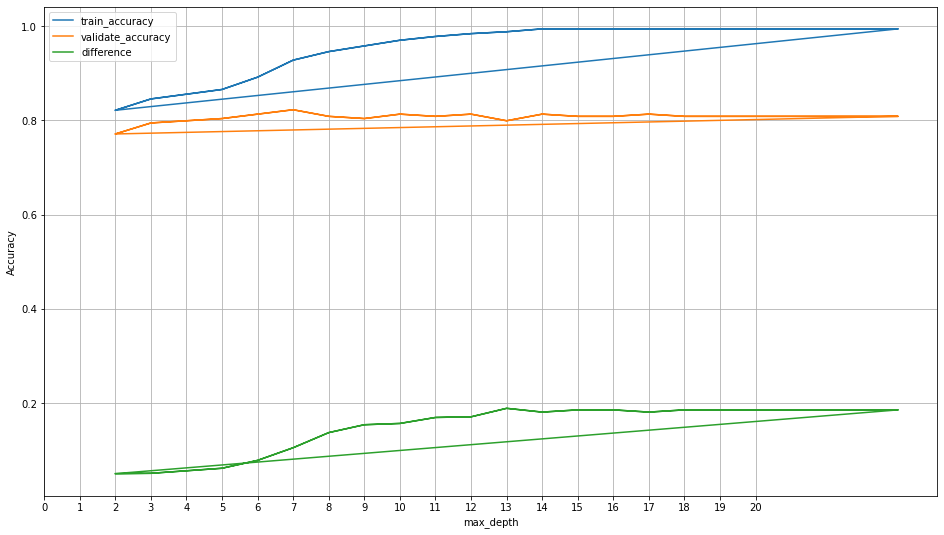

In [48]:

df.set_index('max_depth').plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()


In [53]:
metrics =[]
max_depth = 20

for i in range(2, max_depth):
    #model
    depth = max_depth - i
    n_samples = i
    forest = RandomForestClassifier(max_depth = depth, min_samples_leaf= n_samples, random_state=123)
    
    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)
    
    #use
    #eval on train first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_sample_accuracy = forest.score(X_validate, y_validate)
    
    output = {
        'min_samples_per_leaf': n_samples,
        'max_depth': depth,
        'train_accuracy': in_sample_accuracy,
        'validate_accuracy': out_sample_accuracy
        
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df['difference'] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,18,0.925703,0.822430,0.103273
1,3,17,0.901606,0.817757,0.083849
2,4,16,0.887550,0.817757,0.069793
3,5,15,0.877510,0.780374,0.097136
4,6,14,0.871486,0.799065,0.072421
5,7,13,0.869478,0.789720,0.079758
6,8,12,0.865462,0.794393,0.071069
7,9,11,0.857430,0.794393,0.063037
8,10,10,0.857430,0.785047,0.072383
9,11,9,0.849398,0.785047,0.064351


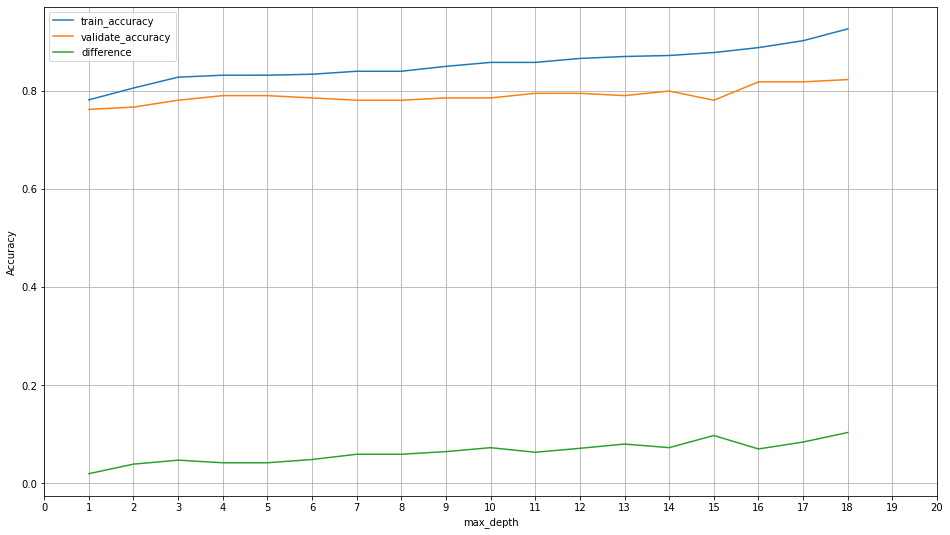

In [54]:
df.set_index('max_depth')[['train_accuracy', 'validate_accuracy','difference']].plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

<AxesSubplot:xlabel='max_depth', ylabel='difference'>

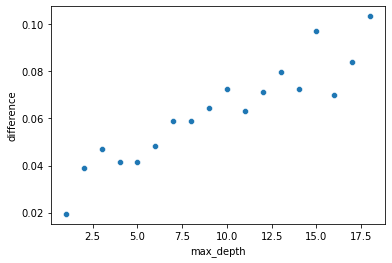

In [55]:
sns.scatterplot(x="max_depth", y="difference", data=df)

<AxesSubplot:xlabel='min_samples_per_leaf', ylabel='difference'>

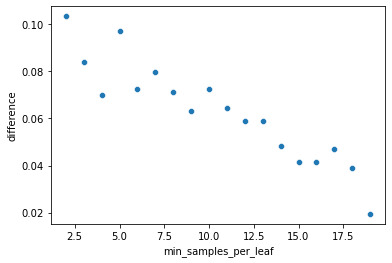

In [56]:
sns.scatterplot(x="min_samples_per_leaf", y="difference", data=df)

<AxesSubplot:xlabel='difference', ylabel='validate_accuracy'>

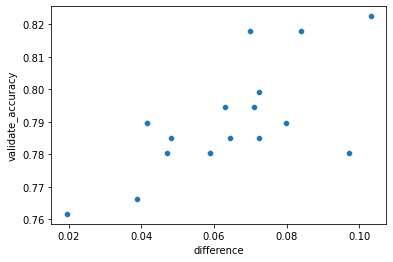

In [58]:
sns.scatterplot(x="difference", y="validate_accuracy", data=df)

# increase min samp per leaf AND max depth

In [59]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []
max_depth = 20

for i in range(2, max_depth):
    # Make the model
    depth = i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,2,0.821285,0.771028,0.050257
1,3,3,0.845382,0.785047,0.060335
2,4,4,0.847390,0.794393,0.052997
3,5,5,0.859438,0.799065,0.060372
4,6,6,0.861446,0.799065,0.062380
5,7,7,0.863454,0.789720,0.073734
6,8,8,0.863454,0.789720,0.073734
7,9,9,0.855422,0.794393,0.061029
8,10,10,0.857430,0.785047,0.072383
9,11,11,0.849398,0.785047,0.064351


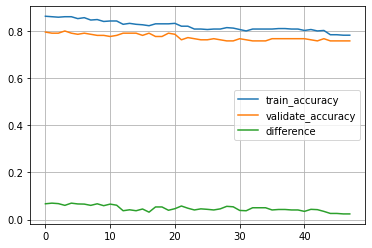

In [63]:
df[['train_accuracy', 'validate_accuracy','difference']].plot()
plt.grid()

# fixed depth and increasing min samp per leaf

In [67]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []


for i in range(2, 50):
    # Make the model
    depth = 5
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,6,0.881526,0.822430,0.059096
1,3,6,0.877510,0.808411,0.069099
2,4,6,0.871486,0.794393,0.077093
3,5,6,0.869478,0.803738,0.065740
4,6,6,0.861446,0.799065,0.062380
5,7,6,0.859438,0.785047,0.074391
6,8,6,0.859438,0.785047,0.074391
7,9,6,0.855422,0.794393,0.061029
8,10,6,0.855422,0.789720,0.065702
9,11,6,0.849398,0.785047,0.064351


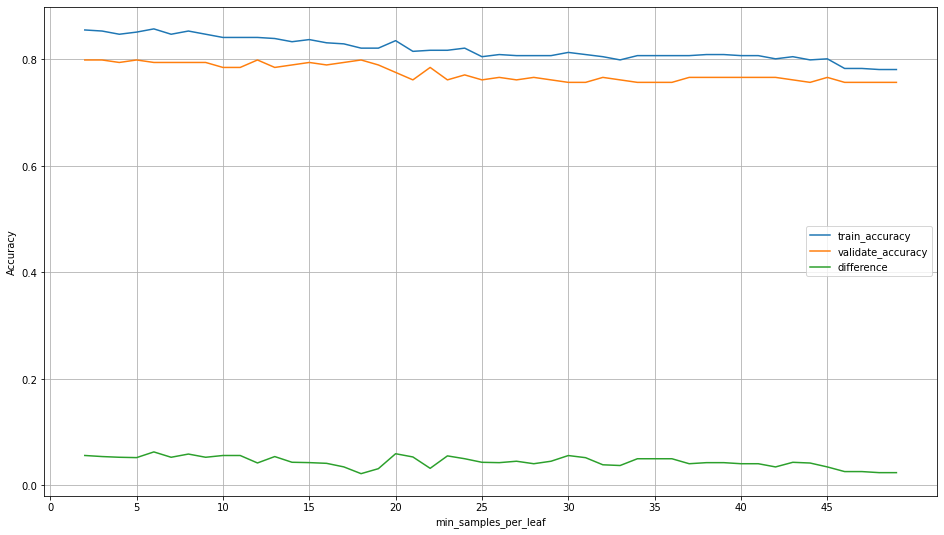

In [66]:
df.set_index('min_samples_per_leaf')[['train_accuracy', 'validate_accuracy', 'difference']].plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,50,5))
plt.grid()

# telco

In [ ]:
df = acquire.get_telco_data()
df.head(2)

In [ ]:
df.drop(columns=['payment_type_id', 'internet_service_type_id', 'contract_type_id', 'customer_id'], inplace=True)

In [ ]:
# Drop object columns for ddecision tree

In [ ]:
df['total_charges'] = df['total_charges'].str.strip()
df = df[df.total_charges != '']

In [ ]:
df.info()

In [ ]:
df['total_charges'] = df.total_charges.astype(float)

In [ ]:
# Convert binary categorical variables to numeric
df['gender_encoded'] = df.gender.map({'Female': 1, 'Male': 0})
df['partner_encoded'] = df.partner.map({'Yes': 1, 'No': 0})
df['dependents_encoded'] = df.dependents.map({'Yes': 1, 'No': 0})
df['phone_service_encoded'] = df.phone_service.map({'Yes': 1, 'No': 0})
df['paperless_billing_encoded'] = df.paperless_billing.map({'Yes': 1, 'No': 0})
df['churn_encoded'] = df.churn.map({'Yes': 1, 'No': 0})

In [ ]:
# Get dummies for non-binary categorical variables
dummy_df = pd.get_dummies(df[['multiple_lines', \
                              'online_security', \
                              'online_backup', \
                              'device_protection', \
                              'tech_support', \
                              'streaming_tv', \
                              'streaming_movies', \
                              'contract_type', \
                              'internet_service_type', \
                              'payment_type']], dummy_na=False, \
                              drop_first=True)

In [ ]:
df = pd.concat([df, dummy_df], axis=1)

In [27]:
# Drop object columns for ddecision tree

In [ ]:
df.info()

In [ ]:
train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df.churn)
train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate.churn)

In [ ]:
train.shape, validate.shape, test.shape

In [ ]:
X_train = train.drop(columns=["churn_encoded"])
y_train = train.churn_encoded

X_validate = validate.drop(columns=["churn_encoded"])
y_validate = validate.churn_encoded

X_test = test.drop(columns=["churn_encoded"])
y_test = test.churn_encoded

In [ ]:
df.churn.head()

In [ ]:
y_train[0:10]

In [ ]:
train.churn_encoded.value_counts()

In [ ]:
# The mode is a great baseline
baseline = y_train.mode()

# Produce a boolean array with True representing a match between the baseline prediction and reality
matches_baseline_prediction = (y_train == 0)

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

# Question 2: Fit-Transform

Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample)

In [ ]:
# Make the model
tree1 = DecisionTreeClassifier(max_depth=1, random_state=123)

# Fit the model (on train and only train)
tree1 = tree1.fit(X_train, y_train)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = tree1.predict(X_train)

Evaluate your in-sample results using the model score, confusion matrix, and classification report.

In [ ]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(tree1.score(X_train, y_train)))